In [11]:
import jax
import jax.numpy as jnp
import optax
import flax.nnx as nnx
from flax.training import train_state
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import jax
import jax.numpy as jnp
import flax.nnx as nnx
from jax import random
from flax import serialization
import json
import optax
import numpy as np
from sklearn.utils.estimator_checks import check_is_fitted
from sklearn.base import BaseEstimator, _fit_context
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from tqdm.notebook import tqdm # progress bar
from sklearn.preprocessing import StandardScaler
import logging
from tqdm import trange
from matplotlib.pyplot import plot
import joblib
import msgpack
import pathlib



In [3]:
features = np.loadtxt("../Data/Training_data/meshsize_features2.txt")[:,2:]#.reshape(-1,1)
labels = np.loadtxt("../Data/Training_data/meshsize_labels2.txt")[:,[0]]

In [7]:
# Split label array into individual columns
true_labels = labels[:, 0]          # Just the actual label
avg_radius_column = labels[:, 1]    # The one you want to move to features

# Reshape so you can concatenate it
avg_radius_column = avg_radius_column.reshape(-1, 1)

# Concatenate to features
features_total_np = np.hstack([features, avg_radius_column])

# Overwrite labels array with only the true label
labels_total_np = true_labels.reshape(-1, 1)

features_total_np = np.delete(features_total_np, [1,4,5,9], axis=1) # Remove variation

IndexError: index 1 is out of bounds for axis 1 with size 1

In [ ]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Standardize input features (only fit on training data!)
scaler = StandardScaler()


X_train = scaler.fit_transform(X_train)
joblib.dump(scaler, 'scaler.pkl')
X_test = scaler.transform(X_test)

X_grid, _, y_grid, _ = train_test_split(X_train, y_train, train_size=0.4, random_state=42) # Only using 40% of the data for gridsearching

# Convert to JAX arrays
X_train = jnp.array(X_train, dtype=jnp.float32)
y_train = jnp.array(y_train, dtype=jnp.float32)

X_test = jnp.array(X_test, dtype=jnp.float32)
y_test = jnp.array(y_test, dtype=jnp.float32)

# X_grid = jnp.array(X_grid, dtype=jnp.float32)
# y_grid = jnp.array(y_grid, dtype=jnp.float32)

In [7]:
X_test.shape

(329139, 7)

In [8]:
# Your MLP model
class MLP(nnx.Module):
    def __init__(self, din, dout, rngs: nnx.Rngs):
        self.linear1 = nnx.Linear(din, 64, rngs=rngs)
        self.linear2 = nnx.Linear(64, 128, rngs=rngs)
        self.linear3 = nnx.Linear(128, 128, rngs=rngs)
        self.linear4 = nnx.Linear(128, 64, rngs=rngs)
        self.linear5 = nnx.Linear(64, dout, rngs=rngs)

    def __call__(self, x):
        x = nnx.relu(self.linear1(x))
        x = nnx.relu(self.linear2(x))
        x = nnx.relu(self.linear3(x))
        x = nnx.relu(self.linear4(x))
        return self.linear5(x)

# Init
model = MLP(X_train.shape[1], 1, rngs=nnx.Rngs(0))
optimizer = nnx.Optimizer(model, optax.adam(1e-3))

# Train step
@nnx.jit
def train_step(model, optimizer, x, y):
    def loss_fn(model):
        preds = model(x)
        return jnp.mean((preds - y) ** 2)

    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)
    return loss

r2_test_history = []
# Training loop
for epoch in trange(400, desc="Training"):
    loss = train_step(model, optimizer, X_train, y_train)
    y_pred_test = optimizer.model(X_test)
    r2_test = r2_score(y_test, np.array(y_pred_test))
    r2_test_history.append(r2_test)



Training: 100%|██████████| 400/400 [13:37<00:00,  2.04s/it]


In [12]:
# Save optimizer (includes model parameters)
with open("model_nnx.msgpack", "wb") as f:
    f.write(serialization.to_bytes(optimizer))

TypeError: can not serialize 'Optimizer' object

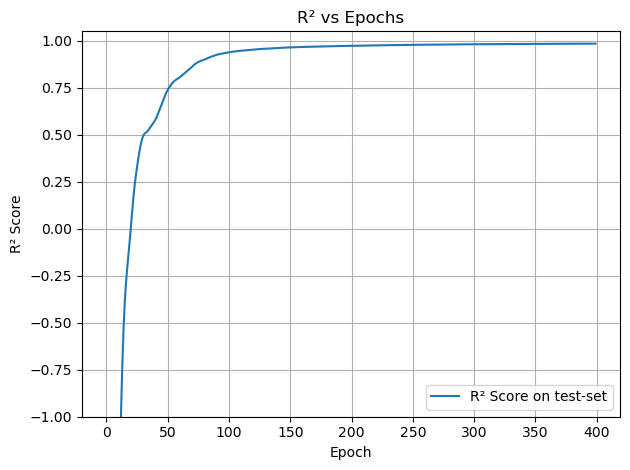

In [13]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

plt.figure()
epochs = list(range(len(r2_test_history)))  # assuming both lists are the same length

# Plotting both curves

plt.plot(epochs, r2_test_history, label="R² Score on test-set")

# Styling
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.title("R² vs Epochs")
plt.ylim(-1, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
plot_r2_progress(r2_history)

NameError: name 'plot_r2_progress' is not defined

In [14]:
# Predict
y_pred = optimizer.model(X_test)


In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error
import numpy as np

# y_true: your ground truth values
# y_pred: your model's predictions

def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    max_err = max_error(y_true, y_pred)

    print(f"📈 Regression Evaluation Metrics")
    print(f"--------------------------------")
    print(f"R² Score         : {r2:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Max Error        : {max_err:.4f}")

In [16]:
print_regression_metrics(y_test, y_pred)

📈 Regression Evaluation Metrics
--------------------------------
R² Score         : 0.9846
Mean Absolute Error (MAE): 0.0377
Mean Squared Error (MSE): 0.0125
Root Mean Squared Error (RMSE): 0.1118
Max Error        : 57.4366


In [138]:
test_features = np.loadtxt("../Data/Training_data/testcloud_feat.txt")[:,2:]#.reshape(-1,1)
test_labels = np.loadtxt("../Data/Training_data/testcloud_lab.txt")[:,[0]]

test_features2 = np.loadtxt("../Data/Training_data/testcloud_feat2.txt")[:,2:]#.reshape(-1,1)
test_labels2 = np.loadtxt("../Data/Training_data/testcloud_lab2.txt")[:,[0]]


test_features3 = np.loadtxt("../Data/Training_data/testcloud_feat3.txt")[:,2:]#.reshape(-1,1)
test_labels3 = np.loadtxt("../Data/Training_data/testcloud_lab3.txt")[:,[0]]

mesh = np.hstack((np.full(len(test_features),1), np.full(len(test_features2),0.5), np.full(len(test_features3),2)))

test_features = np.vstack((test_features,test_features2,test_features3))
test_labels = np.vstack((test_labels,test_labels2,test_labels3))

scaler_reload = joblib.load('scaler.pkl')
X_test2 = scaler_reload.transform(test_features)

X_test2 = jnp.array(X_test2, dtype=jnp.float32)
y_test2 = jnp.array(test_labels, dtype=jnp.float32)


In [156]:
# Predict
y_pred2 = optimizer.model(X_test2)


Standard deviation for 0.5mm mesh: 0.061910614
Standard deviation for 1mm mesh: 0.079023615
Standard deviation for 2mm mesh: 0.04345372
📈 Regression Evaluation Metrics
--------------------------------
R² Score         : 0.9939
Mean Absolute Error (MAE): 0.0508
Mean Squared Error (MSE): 0.0048
Root Mean Squared Error (RMSE): 0.0695
Max Error        : 0.7423


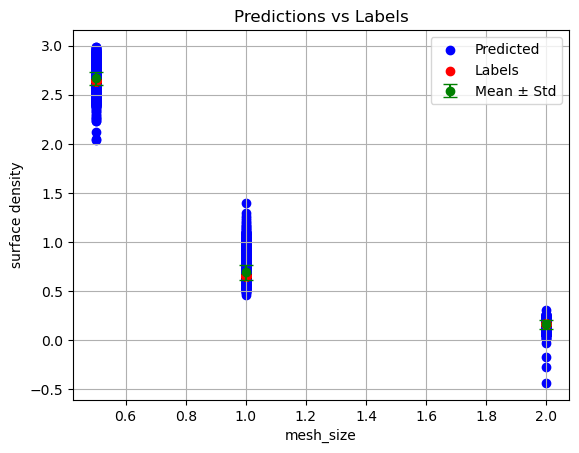

In [155]:
highest = np.max(y_pred2)
mean = np.mean(y_pred2)
#print(test_labels)
#print(mean)
#print(y_pred2)

pred_05 = y_pred2[np.where(mesh == 0.5)]
pred_1 = y_pred2[np.where(mesh == 1)]
pred_2 = y_pred2[np.where(mesh == 2)]

std_05 = np.std(pred_05)
std_1 = np.std(pred_1)
std_2 = np.std(pred_2)
stds = [std_05, std_1, std_2]

print("Standard deviation for 0.5mm mesh:", std_05)
print("Standard deviation for 1mm mesh:", std_1)
print("Standard deviation for 2mm mesh:", std_2)

mean_05 = np.mean(pred_05)
mean_1 = np.mean(pred_1)
mean_2 = np.mean(pred_2)

mesh_short = [0.5, 1, 2]
means = [mean_05, mean_1, mean_2]

print_regression_metrics(y_test2, y_pred2)
#r2 = r2_score(y_test2,y_pred2)
#print(r2)

plt.scatter(mesh, y_pred2, color='blue', label='Predicted')
plt.scatter(mesh, y_test2, color='red', label='Labels')
plt.errorbar(mesh_short, means, yerr=stds, fmt='o', color='green', capsize=5, label='Mean ± Std')
plt.xlabel("mesh_size")
plt.ylabel("surface density")
plt.title("Predictions vs Labels")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Make a fresh optimizer instance to match structure
model_reload = MLP(X_train.shape[1], 1, rngs=nnx.Rngs(0))
optimizer_reload = nnx.Optimizer(model, optax.adam(1e-3))

# Load saved state
with open("model_nnx.msgpack", "rb") as f:
    optimizer_reload = serialization.from_bytes(optimizer, f.read())


In [91]:
np.full((2,3),4)

array([[4, 4, 4],
       [4, 4, 4]])